# Limit setting
Look at the case of a massless neutrino and see how well we can set upper limits given some event rate

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import scipy.constants as const

from utils import ApproxdGammadE, CalcMuSignal, CalcMuBkg

In [2]:
# Allow LaTeX in plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [5]:
def GenerateSignalEvents(numDens: float, tLive: float, volume: float, mNu: float, E0: float,
                         energyWindow: tuple[float, float] = (18.5e3, 18.7e3)):
    """
    Generate simulated neutrino mass events.

    Parameters
    ----------
    numDens : float
        Number density of tritium atoms in m^-3
    tLive : float
        Live time of the detector in seconds
    volume : float
        Effective volume of the detector in m^3
    mNu : float
        Neutrino mass in eV
    E0 : float
        Endpoint energy in eV 
    energyWindow : tuple of float, optional
        Energy window for the events in eV (default is (17.7, 18.7))

    Returns
    -------
    np.ndarray
        Array of generated event energies in keV
    """
    # Calculate the total number of decays in the time and volume
    nAtoms =  numDens * volume
    HALF_LIFE_T = 12.33 * 365.25 * 24 * 3600  # seconds
    DECAY_RATE_T = np.log(2) / HALF_LIFE_T  # s^-1
    N_DECAYS_FULL = nAtoms * DECAY_RATE_T * tLive  # Total decays in the time and volume

    # Need to calculate the decay rate in the energy window
    eMin, eMax = energyWindow
    # Generate the decay rates with a spacing of 5 meV
    energies = np.arange(energyWindow[0], energyWindow[1], 5e-3)  # in eV
    print(energies[0], energies[-1])
    decayRatesSpec = ApproxdGammadE(mNu, E0, energies)
    # Integrate the decay rate over the energy window
    decayRateSpec = np.trapz(decayRatesSpec, energies)
    N_DECAYS_SPEC = nAtoms * decayRateSpec * tLive

    print(f"Total decays in spectrum = {N_DECAYS_FULL:.2e}")
    print(f"Total decays in window: {N_DECAYS_SPEC:.2e}")

    # Generate the events from a Poisson distribution with the mean equal to the 
    # number of decays in the energy window
    nEvents = np.random.poisson(N_DECAYS_SPEC)
    # Draw the energies from the decay rate spectrum
    cdf = np.cumsum(decayRatesSpec * np.diff(energies, prepend=energies[0]))
    cdf /= cdf[-1]  # Normalize to 1
    uniformSamples = np.random.uniform(0, 1, nEvents)
    eventEnergies = np.interp(uniformSamples, cdf, energies)
    return eventEnergies  # Convert to keV

18450.0 18599.995000030558
Total decays in spectrum = 5.62e+12
Total decays in window: 3.28e+06
(30,) (30,)
[3.77852757e+05 3.47685760e+05 3.18770215e+05 2.91106600e+05
 2.64695391e+05 2.39537066e+05 2.15632102e+05 1.92980976e+05
 1.71584165e+05 1.51442145e+05 1.32555393e+05 1.14924385e+05
 9.85495991e+04 8.34315106e+04 6.95705961e+04 5.69673316e+04
 4.56221934e+04 3.55356574e+04 2.67081997e+04 1.91402961e+04
 1.28324222e+04 7.78505383e+03 3.99866649e+03 1.47373568e+03
 2.10736766e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


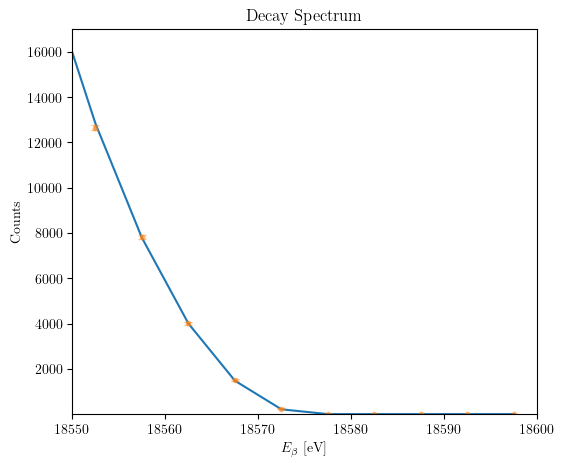

In [7]:
# Plot the decay spectrum
ENERGY_WINDOW = (18.45e3, 18.6e3)  # in eV
ENDPOINT_ENERGY_EV = 18.575e3  # in eV
NU_MASS_EV = 0.0  # in eV

NUM_DENS = 1e17  # in m^-3
T_LIVE = 365.25 * 24 * 3600  # in seconds (1 year)
T_VOLUME = 1e-3  # in m^3 (1 L)

sigEvents0eV = GenerateSignalEvents(NUM_DENS, T_LIVE, T_VOLUME, NU_MASS_EV, 
                                    ENDPOINT_ENERGY_EV, ENERGY_WINDOW)

energyBins = np.arange(ENERGY_WINDOW[0], ENERGY_WINDOW[1] + 5.0, 5.0)  # in eV
sigBins0eV, sigEdges = np.histogram(sigEvents0eV, bins=energyBins)
sigErrors0eV = np.sqrt(sigBins0eV)  # Poisson errors
sigCentres = (sigEdges[:-1] + sigEdges[1:]) / 2  # Bin centres in eV

fix, ax = plt.subplots(1, 1, figsize=(6, 5))
testE = np.linspace(ENERGY_WINDOW[0], ENERGY_WINDOW[1], 1000)

# Sub-divide the energy bins for to integrate the decay rate
sigMu0eV = CalcMuSignal(NU_MASS_EV, ENDPOINT_ENERGY_EV, sigEdges, T_LIVE, 
                        NUM_DENS, T_VOLUME, subdivisionStep=5e-3)

print(sigMu0eV.shape, sigCentres.shape)
print(sigMu0eV)
ax.plot(sigCentres, sigMu0eV, label=r'$d\Gammma / dE$, $m_\nu = 0$ eV')
ax.set_xlabel(r'$E_\beta$ [eV]')
#ax.set_ylabel(r'$\frac{d\Gamma}{dE_\beta}$ [eV$^{-1}$ s$^{-1}$]')
ax.set_ylabel(r'Counts')
ax.set_xlim(18.55e3, 18.6e3)
ax.set_ylim(0.5, 17000)
ax.set_title('Decay Spectrum')

#ax.set_yscale('log')

ax.errorbar(sigCentres, sigBins0eV, yerr=sigErrors0eV, fmt='o', label=r'Simulated events, $m_\nu = 0$ eV', markersize=3, capsize=3, alpha=0.5)

plt.show()

In [ ]:
def GenerateBkgEvents(b: float, tLive: float, energyWindow: tuple[float, float]):
    """
    Generate background events from a flat background rate.

    Parameters
    ----------
    b : float
        Background rate in counts per second per eV
    tLive : float
        Live time of the detector in seconds
    energyWindow : tuple of float, optional
        Energy window for the events in keV (default is (17.7, 18.7))

    Returns
    -------
    np.ndarray
        Array of generated event energies in keV
    """
    nEvents = np.random.poisson(Ca)  # Total events in the energy window
    return np.random.uniform(energyWindow[0], energyWindow[1], nEvents)  # Uniformly distributed in the energy window

def CalculateR(numDens: float, volume: float):
    """
    Calculate the signal rate for a given number density and volume.

    Parameters
    ----------
    numDens : float
        Number density of tritium atoms in m^-3
    volume : float
        Effective volume of the detector in m^3

    Returns
    -------
    float
        Signal rate in counts per second
    """
    MEAN_LIFE_T = 12.33 * 365.25 * 24 * 3600 / np.log(2) # in seconds
    return 2e-13 * numDens * volume / MEAN_LIFE_T
    
def OptimalDeltaE(r: float, b: float):
    """
    Calculate the optimal energy resolution for a given signal and background rate.

    Parameters
    ----------
    r : float
        Signal rate in the last eV
    b : float
        Background rate in counts per second

    Returns
    -------
    float
        Optimal energy resolution in eV
    """
    return np.sqrt(b / r)  # in eV

In [ ]:
myR = CalculateR(NUM_DENS, T_VOLUME)
print(f"Signal rate in last eV {myR:.2e} counts/s")
myB = 1e-6  # Background rate in counts per second per eV
dE = OptimalDeltaE(myR, myB)
print(f"Optimal energy resolution = {dE:.2e} eV")

In [ ]:
# Generate the histogram binning according to the optimal energy resolution
binsOpt = np.arange(ENERGY_WINDOW[0], ENERGY_WINDOW[1] + dE, dE)

# Generate background events
bkgEvents = GenerateBkgEvents(myB, T_LIVE, ENERGY_WINDOW)
print(f"Generated {bkgEvents.shape[0]} background events")

totalEvents = np.concatenate((sigEvents0eV, bkgEvents))
totalHist, totalHistEdges = np.histogram(totalEvents, bins=binsOpt)
totalHistCentres = (totalHistEdges[:-1] + totalHistEdges[1:]) / 2 
totalHistErrors = np.sqrt(totalHist)  # Poisson errors

fix, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.errorbar(totalHistCentres, totalHist, yerr=totalHistErrors, fmt='o', 
            label='Total events', color='C0', markersize=3)
ax.set_xlabel(r'$E_\beta$ [eV]')
ax.set_ylabel('Counts')
ax.set_xlim(ENERGY_WINDOW[0], ENERGY_WINDOW[1])
ax.set_yscale('log')

In [ ]:
def SpectrumModel(energies: np.ndarray, mnu: float, E0: float):
    """
    A neutrino mass spectrum model suitable for fitting with PyMC.

    Parameters
    ----------
    energies : np.ndarray
        Energies at which to evaluate the spectrum in eV.
    mnu : float
        Neutrino mass in eV.
    E0 : float
        Endpoint energy of the beta decay in eV.
    """
    #energies = pt.as_tensor_variable(energies)  # Ensure energies is a tensor variable
    ME_EV = const.m_e * const.c**2 / const.e
    beta = pm.math.sqrt(1.0 - (ME_EV / (energies + ME_EV))**2)
    p = pm.math.sqrt(energies**2 + 2.0 * energies * ME_EV)
    eta = const.alpha * 2 / beta
    fermiFunc = 2 * np.pi * eta / (1. - pm.math.exp(-2 * np.pi * eta))
    nuE = E0 - energies
    fermiConst = 1.1663787e-23  # eV^-2
    rate = fermiConst**2 * 0.97425**2 * fermiFunc * (1 + 3 * (-1.2646)**2) * p * (energies + ME_EV) / (2 * np.pi**3)
    rate *= 1.0 / 6.58e-16  # Account for natural units

    stepCondition = (E0 - energies - mnu) >= 0.0
    spectrum = pm.math.switch(stepCondition, 
                              rate * nuE * pm.math.sqrt(nuE**2 - mnu**2), 0.0)
    return spectrum

In [ ]:
def CalcSigmaMuPyTensor(binEdges, mnu, endpointE, liveTime, numDens, volume, 
                        subdivisionStep=5e-3):
    # Calculate the decay rate on a uniform fine grid
    energyMin, energyMax = binEdges[0], binEdges[1]
    fineEnergies = pt.arange(energyMin, energyMax + subdivisionStep, subdivisionStep)
    decayRates = SpectrumModel(fineEnergies, mnu, endpointE)

    # Vectorised binning of fine grid results
    binIndices = np.digitize(fineEnergies, sigEdges) - 1

    # Check for any edge cases that fall outside the bins
    '''
    valid_mask = (binIndices >= 0) & (binIndices < len(sigEdges) - 1)
    binIndices = binIndices[valid_mask]
    decayRates = decayRates[valid_mask]
    fineEnergies = fineEnergies[valid_mask]
    '''

    sigMu = pt.extra_ops.bincount(binIndices, weights=decayRates * subdivisionStep, 
                                  minlength=len(sigEdges) - 1)
    sigMu *= numDens * liveTime * volume
    return sigMu

In [ ]:
def trapz_pytensor(y, x):
    """
    Perform trapezoidal integration using PyTensor.

    Parameters
    ----------
    y : pytensor.tensor.TensorVariable
        The values to integrate.
    x : pytensor.tensor.TensorVariable
        The x-coordinates corresponding to the y-values.

    Returns
    -------
    pytensor.tensor.TensorVariable
        The result of the trapezoidal integration.
    """
    dx = pt.diff(x)  # Ensure the first element is included
    return pt.sum(0.5 * (y[:-1] + y[1:]) * dx)  # Trapezoidal rule

def IntegrateSpectrumFine_pytensor(x1, x2, mnu: float , E0: float, step=5e-3):
    """
    Integrate the decay spectrum between limits on a fine scale

    Parameters
    ----------
    x1  
        Lower bin edge
    x2  
        Upper bin edge
    mnu : float
        Neutrino mass in eV
    E0 : float
        Endpoint energy in eV
    step : float
        Step size in eV

    Returns
    -------
    float
        The integral of the decay spectrum between limits 
    """

    # Generate the fine-grained values between the limits
    nDivisions = pt.ceil((x2 - x1) / step)
    EFine = pt.linspace(x1, x2, nDivisions + 1)
    # Now use the trapezoidal rule to integrate along here
    return trapz_pytensor(SpectrumModel(EFine, mnu, E0), EFine)

In [ ]:
binEdgesPt = pt.as_tensor_variable(totalHistEdges)
nBins = len(totalHistCentres)
binCentresPt = (binEdgesPt[:-1] + binEdgesPt[1:]) / 2
STEP_SIZE = 5e-3  # eV

with pm.Model() as signalPlusBkg:
    # Define priors
    m_nu = pm.HalfNormal('m_nu', sigma=4.0)  # Neutrino mass in eV
    nT_DIV17 = pm.Normal('nT', mu=NUM_DENS / 1e17, sigma=2e16 / 1e17)
    bkgRate = pm.HalfNormal('bkgRate', sigma=myB * 4)  # Background rate in counts per second per eV
    E0 = ENDPOINT_ENERGY_EV

    bkgMu = bkgRate * T_LIVE * (binEdgesPt[1:] - binEdgesPt[:-1])

    sigMuList = []
    # Calculate the signal rate in each bin
    for i in range(nBins):
        binCont = IntegrateSpectrumFine_pytensor(binEdgesPt[i], binEdgesPt[i + 1], 
                                                 m_nu, E0, STEP_SIZE)
        binCont *= T_LIVE * T_VOLUME * nT_DIV17 * 1e17
        sigMuList.append(binCont)

    sigMu = pt.stack(sigMuList)
    muTot = sigMu + bkgMu
    Y_obs = pm.Poisson('Y_obs', mu=muTot + 1e-40, observed=totalHist)

    trace = pm.sample_prior_predictive(samples=1000)

In [ ]:
pp = trace.prior_predictive

plt.figure(figsize=(10, 6))

plt.fill_between(totalHistCentres, np.percentile(pp.Y_obs[0,:,:], 5.0, axis=0), 
                 np.percentile(pp.Y_obs[0,:,:], 95.0, axis=0), 
                 label='Prior Predictive 90% CI', color='C0', alpha=0.5)
plt.errorbar(totalHistCentres, totalHist, xerr=(totalHistEdges[1]-totalHistEdges[0])/2, 
             yerr=totalHistErrors, fmt='+', label='Observed Data', color='C1', alpha=0.5)
plt.xlabel(r'$E_\beta$ [eV]')
plt.ylabel('Counts')
plt.title('Prior Predictive Distribution')
plt.legend()
plt.yscale('log')
plt.xlim(ENERGY_WINDOW[0], ENERGY_WINDOW[1])
plt.show()

In [ ]:
with signalPlusBkg:
    trace.extend(pm.sample(4000, tune=2000, return_inferencedata=True, target_accept=0.98))
    posterior = pm.sample_posterior_predictive(trace, var_names=['Y_obs'])

In [ ]:
az.plot_trace(trace, combined=False)

In [ ]:
# Plot the posterior predictive distribution
post_pred = posterior.posterior_predictive['Y_obs'].to_numpy().reshape(-1, totalHistCentres.shape[0])
print(f"Posterior predictive shape: {post_pred.shape}")

plt.figure(figsize=(10, 6))
plt.fill_between(totalHistCentres, np.percentile(post_pred, 5.0, axis=0), 
                 np.percentile(post_pred, 95.0, axis=0), 
                 label='Posterior Predictive 90% CI', color='C0', alpha=0.5)
plt.errorbar(totalHistCentres, totalHist, xerr=(totalHistEdges[1]-totalHistEdges[0])/2, 
             yerr=totalHistErrors, fmt='+', label='Observed Data', color='C1', alpha=0.5)
plt.xlabel(r'$E_\beta$ [eV]')
plt.ylabel('Counts')
plt.title('Posterior Predictive Distribution')
plt.legend()
plt.yscale('log')
plt.xlim(ENERGY_WINDOW[0], ENERGY_WINDOW[1])
plt.show()

In [ ]:
# Plot a histogram of the posterior samples for m_nu and show the 1 and two sigma intervals
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
mnuBins = np.linspace(0, 10, 100)
ax[0,0].hist(np.array(trace.posterior['m_nu']).flatten(), bins=40, alpha=0.5)
ax[0,0].set_xlabel(r'$m_\nu$ [eV]')
ax[0,0].set_ylabel('Probability density')
ax[0,0].set_title(r'Posterior Distribution of $m_\nu$')

ax[0,1].hist(np.array(trace.posterior['bkgRate']).flatten(), bins=40, alpha=0.5)
ax[0,1].set_xlabel(r'$b$ [counts/s/eV]')
ax[0,1].set_ylabel('Probability density')
ax[0,1].set_title(r'Posterior Distribution of $b$')

ax[1,0].hist(np.array(trace.posterior['nT']).flatten(), bins=40, alpha=0.5)
ax[1,0].set_xlabel(r'$n_T$ [$10^{17}$ m$^{-3}$]')
ax[1,0].set_ylabel('Probability density')
ax[1,0].set_title(r'Posterior Distribution of $n_T$')

# ax[1,1].hist(np.array(trace.posterior['E0']).flatten(), bins=40, alpha=0.5)
ax[1,1].set_xlabel(r'$E_0$ [eV]')
ax[1,1].set_ylabel('Probability density')
ax[1,1].set_title(r'Posterior Distribution of $E_0$')

plt.show()

In [ ]:
# Plot the correlations of m_nu, bkgRate and nT
az.plot_pair(trace, var_names=['m_nu', 'E0'], kind='kde', figsize=(10, 10),
             marginals=True,
             scatter_kwargs={'s': 10, 'alpha': 0.5, 'color': 'C0'})

In [ ]:
def CreateAndAnalyseData(numDens: float, tLive: float, volume: float, mNu: float, 
                         E0: float, deltaE: float, b: float,
                         energyWindow: tuple[float, float] = (18.5e3, 18.7e3)):
    """
    Create a simulated neutrino mass dataset and then perform a Bayesian 
    analysis to get limits on the parameters

    Parameters
    ----------
    
    numDens : float
        Number density of tritium atoms in m^-3
    tLive : float
        Live time of the detector in seconds
    volume : float
        Effective volume of the detector in m^3
    mNu : float
        Neutrino mass in eV
    E0 : float
        Endpoint energy in eV 
    deltaE : float
        Energy bin width in eV
    b : float
        Background event rate in eV^-1 s^-1
    energyWindow : tuple of float, optional
        Energy window for the events in eV (default is (17.7, 18.7))

    Returns
    -------
    """
    events = np.concatenate((GenerateSignalEvents(numDens, tLive, volume, mNu, E0, energyWindow), 
                             GenerateBkgEvents(b, tLive, energyWindow)))
    bins = np.arange(ENERGY_WINDOW[0], ENERGY_WINDOW[1], deltaE)
    eventHist, eventHistEdges = np.histogram(events, bins=bins)
    eventHistCentres = (eventHistEdges[:-1] + eventHistEdges[1:]) / 2

    with pm.Model() as model:
        # Define priors
        m_nu = pm.Uniform('m_nu', lower=0.0, upper=3.0)  # Neutrino mass in eV
        nT_DIV17 = pm.Normal('nT', mu=numDens / 1e17, sigma=2e16 / 1e17)
        bkgRate = pm.HalfNormal('bkgRate', sigma=b * 4)  # Background rate in counts per second per eV
        E_0 = pm.Normal('E_0', mu=E0, sigma=1.0)  # Endpoint energy in eV
        
        bkgMu = bkgRate * T_LIVE * dE
        # Use the trapezium rule to get an array of expected counts for the signal
        decayRateLower = SpectrumModel(eventHistCentres - deltaE / 2, m_nu, E0)
        decayRateUpper = SpectrumModel(eventHistCentres + deltaE / 2, m_nu, E0)

        sigMu = 0.5 * dE * (decayRateLower + decayRateUpper) * T_LIVE * nT_DIV17 * 1e17 * T_VOLUME
        muTot = sigMu + bkgMu

        Y_obs = pm.Poisson('Y_obs', mu=muTot + 1e-40, observed=eventHist)

    with signalPlusBkg:
        trace = pm.sample_prior_predictive(samples=1000)
        trace.extend(pm.sample(4000, tune=2000, return_inferencedata=True, target_accept=0.99))

    return trace

In [ ]:
trace1eV = CreateAndAnalyseData(NUM_DENS, T_LIVE, T_VOLUME, 0.0, ENDPOINT_ENERGY_EV, 100e-3, myB, ENERGY_WINDOW)

In [ ]:
# Plot a histogram of the posterior samples for m_nu and show the 1 and two sigma intervals
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].hist(np.array(trace1eV.posterior['m_nu']).flatten(), bins=40, density=True, alpha=0.5)
ax[0,0].set_xlabel(r'$m_\nu$ [eV]')
ax[0,0].set_ylabel('Probability density')
ax[0,0].set_title(r'Posterior Distribution of $m_\nu$')

ax[0,1].hist(np.array(trace1eV.posterior['bkgRate']).flatten(), bins=40, density=True, alpha=0.5)
ax[0,1].set_xlabel(r'$b$ [counts/s/eV]')
ax[0,1].set_ylabel('Probability density')
ax[0,1].set_title(r'Posterior Distribution of $b$')

ax[1,0].hist(np.array(trace1eV.posterior['nT']).flatten(), bins=40, density=True, alpha=0.5)
ax[1,0].set_xlabel(r'$n_T$ [$10^{17}$ m$^{-3}$]')
ax[1,0].set_ylabel('Probability density')
ax[1,0].set_title(r'Posterior Distribution of $n_T$')

ax[1,1].hist(np.array(trace1eV.posterior['E0']).flatten(), bins=40, density=True, alpha=0.5)
ax[1,1].set_xlabel(r'$E_0$ [eV]')
ax[1,1].set_ylabel('Probability density')
ax[1,1].set_title(r'Posterior Distribution of $E_0$')

## Using unbinned model data

In [ ]:
from scipy.integrate import quad

def CreateAndAnalyseUnbinnedData(numDens: float, tLive: float, volume: float, 
                                 mNu: float, E0: float,  b: float,
                                 energyWindow: tuple[float, float] = (18.5e3, 18.7e3)):
    """
    Create a simulated neutrino mass dataset and then perform a Bayesian 
    analysis to get limits on the parameters

    Parameters
    ----------
    
    numDens : float
        Number density of tritium atoms in m^-3
    tLive : float
        Live time of the detector in seconds
    volume : float
        Effective volume of the detector in m^3
    mNu : float
        Neutrino mass in eV
    E0 : float
        Endpoint energy in eV 
    b : float
        Background event rate in eV^-1 s^-1
    energyWindow : tuple of float, optional
        Energy window for the events in eV (default is (17.7, 18.7))

    Returns
    -------
    """
    events = GenerateSignalEvents(numDens, tLive, volume, mNu, E0, energyWindow)

    with pm.Model() as model:
        # Define priors
        m_nu = pm.Uniform('m_nu', lower=0.0, upper=10.0)  # Neutrino mass in eV
        E_0 = pm.Normal('E_0', mu=E0, sigma=1.0)  # Endpoint energy in eV

        # Compute a normalised spectrum to facilitate calculating the LL
        energyGrid = np.arange(energyWindow[0], energyWindow[1], 5e-3)  # in eV
        def normalisedSpectrum(nuMass, endpointE):
            unnorm = SpectrumModel(energyGrid, nuMass, endpointE)
            norm = pt.sum(unnorm * (energyGrid[1] - energyGrid[0]))
            return unnorm / norm  

        def ComputeLL(EVals, m_nu, E_0):
            pdfVals = normalisedSpectrum(m_nu, E_0)
            # Interpolate between the pre-calculated points to get the PDF at
            # the observed events
            interpVals = pt.interp(EVals, energyGrid, pdfVals)
            return pt.sum(pm.math.log(interpVals + 1e-40))

        logp = ComputeLL(events, m_nu, E_0)
        pm.Potential("unbinned", logp)

        #trace = pm.sample_prior_predictive(samples=1000)
        trace.extend(pm.sample(4000, tune=2000, return_inferencedata=True, step=pm.Metropolis()))

    return trace

In [ ]:
traceUnbinned = CreateAndAnalyseUnbinnedData(NUM_DENS, T_LIVE, T_VOLUME, 0.0, 
                                             ENDPOINT_ENERGY_EV, myB, (18.55e3, 18.6e3))

In [ ]:
# Plot a histogram of the posterior samples for m_nu and show the 1 and two sigma intervals
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].hist(np.array(traceUnbinned.posterior['m_nu']).flatten(), bins=40, density=True, alpha=0.5)
ax[0,0].set_xlabel(r'$m_\nu$ [eV]')
ax[0,0].set_ylabel('Probability density')
ax[0,0].set_title(r'Posterior Distribution of $m_\nu$')

ax[0,1].hist(np.array(traceUnbinned.posterior['bkgRate']).flatten(), bins=40, density=True, alpha=0.5)
ax[0,1].set_xlabel(r'$b$ [counts/s/eV]')
ax[0,1].set_ylabel('Probability density')
ax[0,1].set_title(r'Posterior Distribution of $b$')

ax[1,0].hist(np.array(traceUnbinned.posterior['nT']).flatten(), bins=40, density=True, alpha=0.5)
ax[1,0].set_xlabel(r'$n_T$ [$10^{17}$ m$^{-3}$]')
ax[1,0].set_ylabel('Probability density')
ax[1,0].set_title(r'Posterior Distribution of $n_T$')

ax[1,1].hist(np.array(traceUnbinned.posterior['E0']).flatten(), bins=40, density=True, alpha=0.5)
ax[1,1].set_xlabel(r'$E_0$ [eV]')
ax[1,1].set_ylabel('Probability density')
ax[1,1].set_title(r'Posterior Distribution of $E_0$')